# Курсовой проект «Введение в обработку естественного языка»

**Задание:**

Реализовать чат-бот на базе API Telegram.

**Состав:**

1. болталка (разговорная часть): используются вопросы-ответы mail.ru,
2. суммаризация: используется предобученная модель - csebuetnlp/mT5_multilingual_XLSum
3. продуктовая часть: используются данные с youla.ru.

**Составляющие:**

ML: CountVectorizer, TfidfVectorizer, FastText, MorphAnalyzer, dialogflow, LogisticRegression, annoy,
API: telegram


**Алгоритм:**

При поступлении текстового запроса модель должна определить интент к которому относится запрос:

* болталка (вопрос/ответ)
* суммаризация
* поиск продукта

1. Если запрос "разговорный", используя TfidfVectorizer, FastText, annoy определяется наиболее подходящий ответ.

2. Если интент "cуммаризация", то используется предобученная модель csebuetnlp/mT5_multilingual_XLSum. Суммаризация должна начинаться с ключевого слова "Summarization:".

3. Если запрос "продуктовый", используя TfidfVectorizer, FastText, annoy (быстрый поиск ближайших соседей). Определяются N наиболее похожих продукта, которые возвращяются в чат.

4. Если в разговорном и продуктовом запросе найденный ответ слабо соответствует запросу, чат-бот должен ответить "Не понимаю запрос. Сформулируйте запрос более корректно.".``

## 1. Установка библиотек и подготовка данных.

In [3]:
import os
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import re

## 2.Обучение разговорной модели

In [5]:
%%time
# работает быстро

assert True

#Small preprocess of the answers

question = None
written = False

c=0

# Идем по всем записям, берем строку как вопрос и после знака "---" находим ответ
with open("prepared_answers.txt", "w") as fout:
    with open("./data/Otvety.txt", "r", encoding="Windows-1251", errors='ignore') as fin:
        for line in tqdm_notebook(fin):
            if line.startswith("---"):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue

<timed exec>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

CPU times: total: 43.7 s
Wall time: 44.2 s


### Предобработка текста

In [4]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [5]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [8]:
assert True

# Preprocess for models fitting

sentences = []
c = 0

with open("./data/Otvety.txt", "r", encoding="Windows-1251", errors='ignore') as fin:
    for line in tqdm_notebook(fin):
        spls = preprocess_txt(line)
        sentences.append(spls)
        c += 1
        if c > 500000:
            break

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_37796\3440605189.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

In [9]:
sentences = [i for i in sentences if len(i) > 2]

# записываем сериализованный объект в файл
with open(f'sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)

In [12]:
# загружаем объект из файла
with open(f'sentences.pkl', 'rb') as f:
    sentences = pickle.load(f)

### Обучение модели TF-IDF

In [13]:
# Функция-пустышка, для возможности передать в TfidfVectorizer список уже готовых токенов, а не текст
def simple_tokenizer(x):
    return x

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
%%time
tfidf_vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=2)
tfidf_vectorizer.fit_transform(sentences)

idfs = {v[0]: v[1] for v in zip(tfidf_vectorizer.vocabulary_, tfidf_vectorizer.idf_)}
midf = np.mean(tfidf_vectorizer.idf_)

with open(f'idfs.pkl', 'wb') as f:
    pickle.dump(idfs, f)  # записывает сериализованный объект в файл.
    
with open(f'midf.pkl', 'wb') as f:
    pickle.dump(midf, f)  # записывает сериализованный объект в файл.

C:\Users\Mikhail\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 13.9 s
Wall time: 14 s


In [16]:
with open(f'idfs.pkl', 'rb') as f:
    idfs = pickle.load(f)  # загружает объект из файла

In [17]:
with open(f'midf.pkl', 'rb') as f:
    midf = pickle.load(f)  # загружает объект из файла

### Обучение модели FastText

In [18]:
SIZE_EMB = 200  # Размер эмбеддинга

In [6]:
def embed_txt(txt, idfs, model, midf):
    n_ft = 0
    vector_ft = np.zeros(SIZE_EMB)
    for word in txt:
        if word in model:
            vector_ft += model[word] * idfs.get(word, midf)
            n_ft += idfs.get(word, midf)
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
        
    return vector_ft

In [21]:
%%time
modelFT = FastText(sentences=sentences, vector_size=SIZE_EMB, min_count=2, window=5, seed=34)
modelFT.save("ft_model")

CPU times: total: 36min 37s
Wall time: 13min 33s


In [24]:
%%time

modelFT = FastText.load("ft_model")
ft_index = annoy.AnnoyIndex(SIZE_EMB ,'angular')

index_map = {}
counter = 0

with open("prepared_answers.txt", "r") as f:
    for line in tqdm_notebook(f):
        n_ft = 0
        spls = line.split("\t")
        index_map[counter] = re.sub(r'\<[^>]*\>', '', spls[1]) # Удалим html-тэги
        question = preprocess_txt(spls[0])
        vector_ft = np.zeros(SIZE_EMB)

        for word in question:
            if word in modelFT.wv:
                vector_ft += modelFT.wv[word]
                # n_ft += 1
                n_ft += idfs.get(word, midf)

        if n_ft > 0:
            vector_ft = vector_ft / n_ft
        ft_index.add_item(counter, vector_ft)
            
        counter += 1
        if counter > 500000:
            break

ft_index.build(10)
ft_index.save('ft_index.ann')

# Сохраняем индекс вопросов из болталки
with open(f'index_map.pkl', 'wb') as f:   # Save it for future use
    pickle.dump(index_map, f)  # записывает сериализованный объект в файл

<timed exec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [25]:
ft_index = annoy.AnnoyIndex(SIZE_EMB, 'angular')  # Создание Annoy индекса
ft_index.load(f'ft_index.ann')  # загружает 

In [26]:
ft_index = annoy.AnnoyIndex(SIZE_EMB, 'angular')  # Создание Annoy индекса
ft_index.load(f'/content/drive/MyDrive/06_lang/course_proj/ft_index.ann')  # загружает 

In [27]:
# with open(f'index_map.pkl', 'rb') as f:
#     index_map = pickle.load(f)  # загружает объект из файла

In [28]:

with open(f'/content/drive/MyDrive/06_lang/course_proj/index_map.pkl', 'rb') as f:
    index_map = pickle.load(f)  # загружает объект из файла

In [29]:
ft_index.get_nns_by_vector(np.zeros(SIZE_EMB), 2)

## 3. Обучение продуктовых моделей

In [30]:
%%time

shop_data = pd.read_csv("./data/ProductsDataset.csv")
shop_data['text'] = shop_data['title'] + " " + shop_data["descrirption"]
shop_data['text'] = shop_data['text'].apply(lambda x: preprocess_txt(str(x)))
shop_data.head()

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(ngram_range=(1, 2))

In [32]:
%%time

idxs = set(np.random.randint(0, len(index_map), len(shop_data)))
negative_texts = [" ".join(preprocess_txt(index_map[i])) for i in idxs]
positive_texts = [" ".join(val) for val in shop_data['text'].values]

In [33]:
dataset = negative_texts + positive_texts
labels = np.zeros(len(dataset))
labels[len(negative_texts):] = np.ones(len(positive_texts))

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels,
                                                    random_state=13)

Модуль CountVectorizer в sklearn позволяет сконвертировать набор текстов в матрицу токенов, находящихся в тексте.

In [35]:
%%time

x_train_vec = vectorizer.fit_transform(X_train)
x_test_vec = vectorizer.transform(X_test)

lr = LogisticRegression().fit(x_train_vec, y_train)

In [36]:
with open(f'vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [37]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
with open(f'vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [38]:
with open(f'lr.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [39]:
lr = LogisticRegression()
with open(f'lr.pkl', 'rb') as f:
    lr = pickle.load(f)

In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=lr.predict(x_test_vec))

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer().fit(X_train)

### Обучение модели TF-IDF

In [42]:
%%time
tfidf_vect_prod = TfidfVectorizer(lowercase=False, min_df=2)
tfidf_vect_prod.fit(X_train)

idfs_prod = {v[0]: v[1] for v in zip(tfidf_vect_prod.vocabulary_, tfidf_vect_prod.idf_)}
midf_prod = np.mean(tfidf_vect_prod.idf_)

with open(f'idfs_prod.pkl', 'wb') as f:
    pickle.dump(idfs_prod, f)
with open(f'midf_prod.pkl', 'wb') as f:
    pickle.dump(midf_prod, f)

In [43]:
with open(f'idfs_prod.pkl', 'rb') as f:
    idfs_prod = pickle.load(f)

In [44]:
with open(f'midf_prod.pkl', 'rb') as f:
    midf_prod = pickle.load(f)

## Annoy. Алгоритм приблизительного поиска

In [45]:
%%time
ft_index_shop = annoy.AnnoyIndex(SIZE_EMB ,'angular')
index_map_shop = {}
counter = 0

for i in tqdm_notebook(range(len(shop_data))):
    n_ft = 0
    index_map_shop[counter] = (shop_data.loc[i, "title"], shop_data.loc[i, "image_links"])
    vector_ft = np.zeros(SIZE_EMB)
    for word in shop_data.loc[i, "text"]:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * idfs.get(word, midf_prod)
            n_ft += idfs.get(word, midf_prod)
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
    ft_index_shop.add_item(counter, vector_ft)
    counter += 1

ft_index_shop.build(50)
# ft_index_shop.save('shop.ann')
ft_index_shop.save(f'ft_index_shop')

with open(f'index_map_shop.pkl', 'wb') as f:
    pickle.dump(index_map_shop, f)  # записывает сериализованный объект в файл.

In [46]:
ft_index_shop = annoy.AnnoyIndex(SIZE_EMB, 'angular')
ft_index_shop.load(f'ft_index_shop') 

In [47]:
with open(f'index_map_shop.pkl', 'rb') as f:
    index_map_shop = pickle.load(f)

# БОТ

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import MBartTokenizer, MBartForConditionalGeneration

In [8]:
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_mT5_multilingual_XLSum = AutoModelForSeq2SeqLM.from_pretrained(model_name)

C:\Users\Mikhail\anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [9]:
import os
from telegram.ext import Updater, CommandHandler, MessageHandler, filters, CallbackContext
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import re

from telegram import Update
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

SIZE_EMB = 200  # Размер эмбеддинга

In [10]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

## Загрузка моделей

In [11]:
with open(f'idfs.pkl', 'rb') as f:
    idfs = pickle.load(f)

with open(f'midf.pkl', 'rb') as f:
    midf = pickle.load(f)

with open(f'idfs_prod.pkl', 'rb') as f:
    idfs_prod = pickle.load(f)  # загружает объект из файла

with open(f'midf_prod.pkl', 'rb') as f:
    midf_prod = pickle.load(f)  # загружает объект из файла

# Подгружаем предварительно обученную модель вопросов из болталки
modelFT = FastText.load(f'ft_model')

# Подгружаем предварительно подготовленный и сохранненый индекс ответов из болталки
ft_index = annoy.AnnoyIndex(SIZE_EMB, 'angular')
ft_index.load(f'ft_index.ann')
with open(f'index_map.pkl', 'rb') as f:
    index_map = pickle.load(f)  # загружает объект из файла

vectorizer = CountVectorizer(ngram_range=(1, 2))
with open(f'vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

lr = LogisticRegression()
with open(f'lr.pkl', 'rb') as f:
    lr = pickle.load(f)

with open(f'midf_prod.pkl', 'rb') as f:
    midf_p = pickle.load(f)

ft_index_shop = annoy.AnnoyIndex(SIZE_EMB, 'angular')
ft_index_shop.load(f'ft_index_shop') 

# Подгружаем предварительно обученную модель продуктовых названий
with open(f'index_map_shop.pkl', 'rb') as f:
    index_map_shop = pickle.load(f)

In [12]:
updater = Updater("6123779874:AAEhveWcBqWvX6S2d5fycmoUoodJynuuYO0", use_context=True)  # Токен API к Telegram

def echo(update: Update, context: CallbackContext):
    txt = update.message.text
    update.message.reply_text('Ваше сообщение! ' + update.message.text)


def startCommand(update: Update, context: CallbackContext) -> None:
    update.message.reply_text('Доброго времени суток! Как дела, как Ваше ничего?')


def model_mT5_multilingual_XLSum_summary(input_text, model, tokenizer): 
    """ 
        Суммаризация. Предобученную модель: csebuetnlp/mT5_multilingual_XLSum
    """
    WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

    input_ids = tokenizer(
        [WHITESPACE_HANDLER(input_text)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]

    summary = tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return summary


def textMessage(update: Update, context: CallbackContext) -> None:
    
    # 1. Суммаризация. Начало фразы с ключевого слова "Summarization:"
    input_text = update.message.text
    if input_text.split(' ', 1)[0] == 'Summarisation:':
      update.message.reply_text('Подождите, идет суммаризация текста ...')

      input_text = input_text.replace('Summarisation:', '')
      summary = model_mT5_multilingual_XLSum_summary(input_text, model_mT5_multilingual_XLSum, tokenizer)
      update.message.reply_text('Суммаризация: ' + summary)

    else:
      res_text = 'Не понимаю запрос. Сформулируйте запрос более корректно.'
      input_txt = preprocess_txt(update.message.text)
      vect = vectorizer.transform([" ".join(input_txt)])
      prediction = lr.predict(vect)
      
      # 2. Определим является ли запрос продуктовым.
      if prediction[0] == 1:
          # Если запрос продуктовый, то найдём 3 самых подходящих товара.
          update.message.reply_text('Продуктовый ...')
          find = False
          vect_ft = embed_txt(input_txt, idfs_prod, modelFT.wv, midf_prod)
          ft_index_shop_val, distances_shop = ft_index_shop.get_nns_by_vector(vect_ft, 3, include_distances=True)

          for i, item in enumerate(ft_index_shop_val):
              if distances_shop[i] <= 0.5:          
                title, image = index_map_shop[item]
                print(title, image)
                update.message.reply_text("title: {} image: {}".format(title, image))
                find = True
          if find == False:
            update.message.reply_text(res_text)

      else:
          # 3. Если запрос разговорный, то найдём ответ.
          update.message.reply_text('Разговорный ...')
          vect_ft = embed_txt(input_txt, idfs, modelFT.wv, midf)
          ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
          if distances[0] <= 0.9:
              update.message.reply_text(index_map[ft_index_val[0]])
          else:
              update.message.reply_text(res_text)

In [13]:
dispatcher = updater.dispatcher  # Диспетчер

# on different commands - answer in Telegram
dispatcher.add_handler(CommandHandler('start', startCommand))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, textMessage))

# Start Bot
updater.start_polling()
updater.idle()

Сумка http://cache3.youla.io/files/images/360_360/58/ef/58ef1dce65bcf11c0f6ed773.jpg
Сумка http://cache3.youla.io/files/images/360_360/5b/11/5b117b0fb261ff35aa78b4b3.jpg
Сумка http://cache3.youla.io/files/images/360_360/5b/e8/5be840ddde885488c41ccd75.jpg


### Результаты:

Болталка


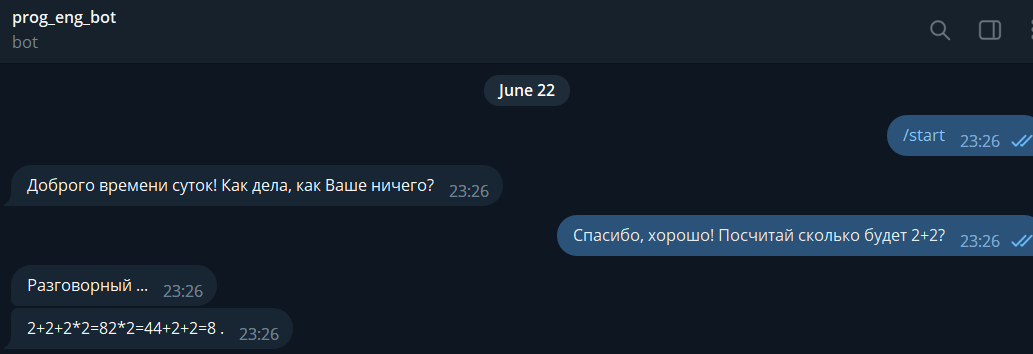

In [14]:
from IPython.display import Image
print('Болталка')
Image("img1.png", width=320, height=240) 

**Вывод: Математика уровня "Бог"**

Покупки:


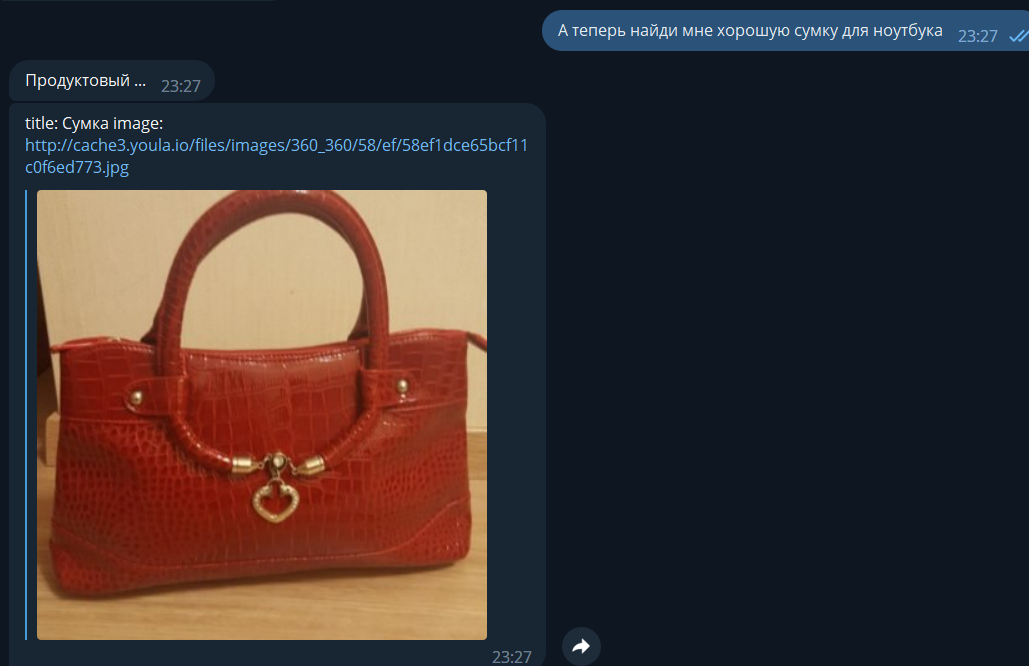

In [17]:
print('Покупки:')
Image("img2.png", width=320, height=240) 

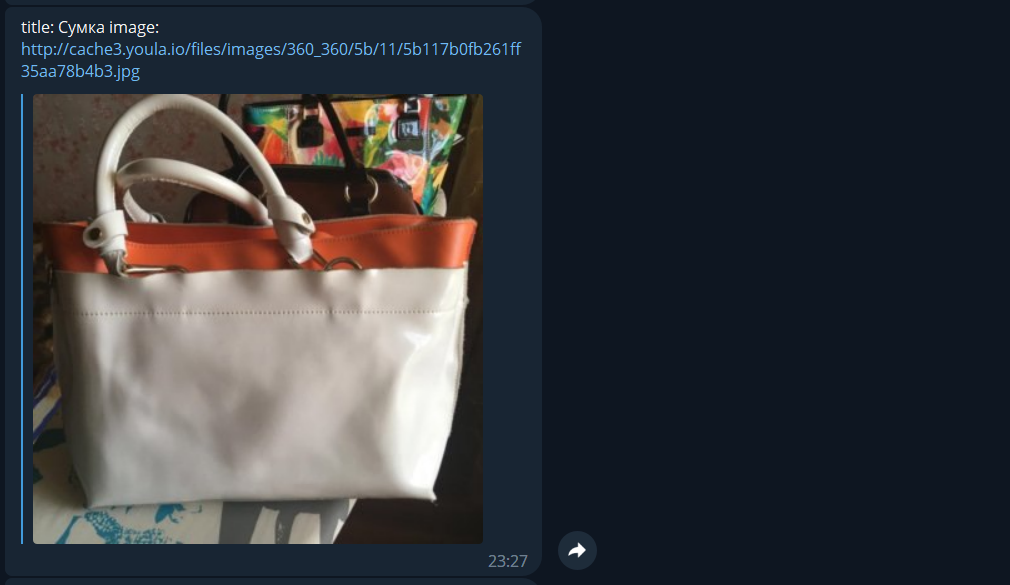

In [18]:
Image("img3.png", width=320, height=240) 

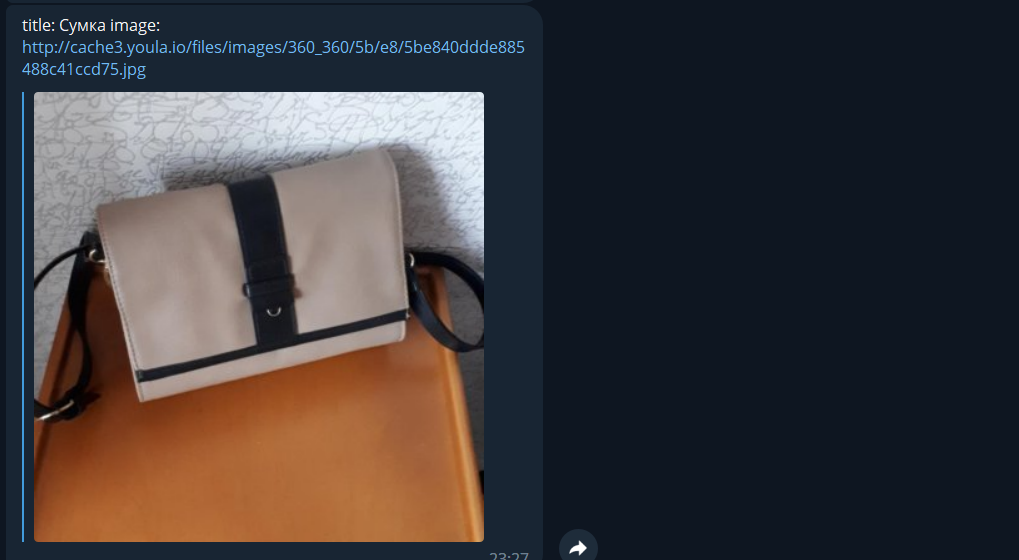

In [19]:
Image("img4.png", width=320, height=240) 

**Сумка да, ноутбук - однозначно нет((**

Суммаризация:


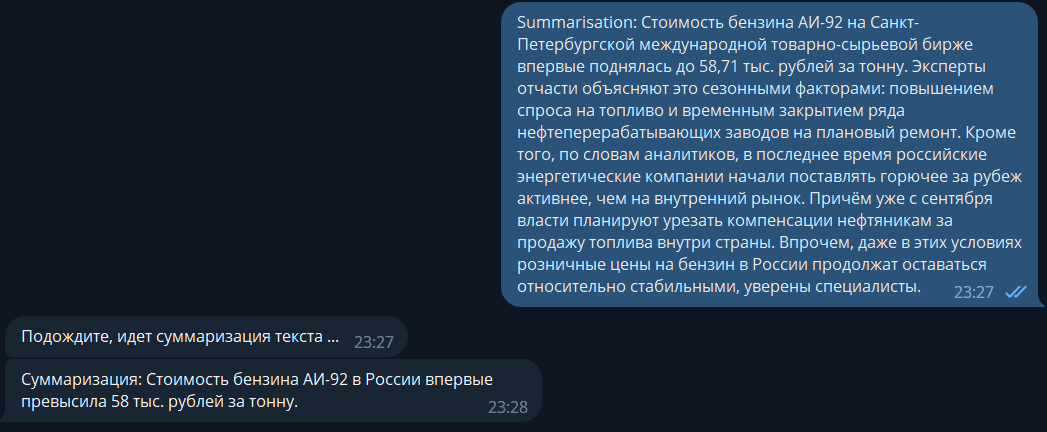

In [22]:
print('Суммаризация:')
Image("img5.png", width=320, height=240) 

#### Общий вывод:

Суммаризация работает лучше всего. Что естественно, т.к. используется предобученная модель. Остальное - на улыбнуться. Ну или совершенно другое время/ресурсы на обучение потратить